based on [Beginners Tutorial: Analyze guns deaths in the US | Kaggle](https://www.kaggle.com/hakabuk/beginners-tutorial-analyze-guns-deaths-in-the-us)

# Beginners Tutorial: Analyze guns deaths in the US w/ Python
## Analyzation Gun Deaths in the US: 2012-2014

This analyzation inspects gun-death in the US in the years 2012-2014. The data originated from the CDC. I came across this thanks to FiveThirtyEight's [Gun Deaths in America][1] project. The data can be found [here][2].

  [1]: https://fivethirtyeight.com/features/gun-deaths/
  [2]: https://github.com/fivethirtyeight/guns-data

This notebook was made for learning purposes. It definitely served its purpuse and I hope others can make use of it. I believe a beginner can learn a lot from it. 

**If you're here for the visualizations: skip to the "Visualization" part. 

## 1. Importing, cleaning and getting familiar with the data

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
guns = pd.read_csv('./full_data.csv', index_col=0)
print(guns.shape)
guns.head()

(100798, 10)


,year,month,intent,police,sex,age,race,hispanic,place,education
1,2012,1,Suicide,0,M,34.0,Asian/Pacific Islander,100,Home,BA+
2,2012,1,Suicide,0,F,21.0,White,100,Street,Some college
3,2012,1,Suicide,0,M,60.0,White,100,Other specified,BA+
4,2012,2,Suicide,0,M,64.0,White,100,Home,BA+
5,2012,2,Suicide,0,M,31.0,White,100,Other specified,HS/GED


In [3]:
# need to remap Education to 1-5 scale

guns.education.value_counts()

HS/GED          42927
Less than HS    21823
Some college    21680
BA+             12946
Name: education, dtype: int64

In [4]:
ed_map = {
    'Less than HS': 1,
    'HS/GED': 2,
    'Some college': 3,
    'BA+': 4
}

In [5]:
guns.education = guns.education.apply(lambda s: ed_map.get(s, 5))

Our data has almost 101,000 rows (gun death incidents) and 10 columns (categories).

Here's an explanation of each column:

- **' '**: this is an identifier column, which contains the row number. It's common in CSV files to include a unique identifier for each row, but we can ignore it in this analysis.
- **year**: the year in which the fatality occurred.
- **month**: the month in which the fatality occurred.
- **intent**: the intent of the perpetrator of the crime. This can be Suicide, Accidental, NA, Homicide, or Undetermined.
- **police**: whether a police officer was involved with the shooting. Either 0 (false) or 1 (true).
- **sex**: the gender of the victim. Either M or F.
- **age**: the age of the victim.
- **race**: the race of the victim. Either Asian/Pacific Islander, Native American/Native Alaskan, Black, Hispanic, or White.
- **hispanic**: a code indicating the Hispanic origin of the victim.
- **place**: where the shooting occurred. Has several categories, which you're encouraged to explore on your own.
- **education**: educational status of the victim. Can be one of the following:
    + **1**: Less than High School
    + **2**: Graduated from High School or equivalent
    + **3**: Some College
    + **4**: At least graduated from College
    + **5**: Not available

It's good practice to get to know our data set before begining to analyze. 

In [6]:
guns.index.name = 'Index'
guns.head()

,year,month,intent,police,sex,age,race,hispanic,place,education
Index,,,,,,,,,,
1,2012,1,Suicide,0,M,34.0,Asian/Pacific Islander,100,Home,4
2,2012,1,Suicide,0,F,21.0,White,100,Street,3
3,2012,1,Suicide,0,M,60.0,White,100,Other specified,4
4,2012,2,Suicide,0,M,64.0,White,100,Home,4
5,2012,2,Suicide,0,M,31.0,White,100,Other specified,2


In [7]:
# for readability and concistency - capitalizing column names
guns.columns = map(str.capitalize, guns.columns)
guns.columns

Index(['Year', 'Month', 'Intent', 'Police', 'Sex', 'Age', 'Race', 'Hispanic',
       'Place', 'Education'],
      dtype='object')

In [8]:
guns.dtypes

Year           int64
Month          int64
Intent        object
Police         int64
Sex           object
Age          float64
Race          object
Hispanic       int64
Place         object
Education      int64
dtype: object

The float values in the education column could indicate there are NaN valuse, since every category is a whole number [1,2,3,4,5].

**Incompeteness/ Completeness**: checking to see how much of the data is NaN is important in order to know if the column is usefull/ useless.

In [9]:
guns.notnull().sum()

Year         100798
Month        100798
Intent       100797
Police       100798
Sex          100798
Age          100780
Race         100798
Hispanic     100798
Place         99414
Education    100798
dtype: int64

In [10]:
# In order to see the percentage of valid data:
guns.notnull().sum() * 100.0/guns.shape[0]

Year         100.000000
Month        100.000000
Intent        99.999008
Police       100.000000
Sex          100.000000
Age           99.982143
Race         100.000000
Hispanic     100.000000
Place         98.626957
Education    100.000000
dtype: float64

It seems that most of the columns have a at least 98.6% of the values - which means the data is close to complete (unlike real world data). That means we could probably delete all rows with NaN values and still not loose that much of our potential insights.

Let's try to substitute as many NaN's as we can with real value, and then delete the rows we couldn't fill.

In [11]:
# Organizing the data by a column value: first by the year, then by month:
guns.sort_values(['Year', 'Month'], inplace=True)
guns.head(10)

,Year,Month,Intent,Police,Sex,Age,Race,Hispanic,Place,Education
Index,,,,,,,,,,
1,2012,1,Suicide,0,M,34.0,Asian/Pacific Islander,100,Home,4
2,2012,1,Suicide,0,F,21.0,White,100,Street,3
3,2012,1,Suicide,0,M,60.0,White,100,Other specified,4
12,2012,1,Suicide,0,M,21.0,Native American/Native Alaskan,100,Home,2
135,2012,1,Suicide,0,F,59.0,White,100,Home,2
136,2012,1,Suicide,0,F,30.0,White,100,Other unspecified,4
137,2012,1,Homicide,0,M,58.0,Black,100,Home,1
138,2012,1,Suicide,0,M,78.0,White,100,Home,4
139,2012,1,Suicide,0,M,60.0,White,100,Other unspecified,1


For me, the most interesting column is 'Intent'. This is what I would want to predict.

## 2. Exploring and analyzing the data

In [12]:
guns.Intent.value_counts(ascending=False)

Suicide         63175
Homicide        35176
Accidental       1639
Undetermined      807
Name: Intent, dtype: int64

In [13]:
# Looking at the normalized values makes the picture clearer.
# Note: 'normalize=False' excludes the 'NaN's where here it includes them
guns.Intent.value_counts(ascending=False, dropna=False, normalize=True)

Suicide         0.626749
Homicide        0.348975
Accidental      0.016260
Undetermined    0.008006
NaN             0.000010
Name: Intent, dtype: float64

It is interesting that while suicide does not sound like the most common gun death in the US, it amounted to almost 2/3 of the gun deaths in 2012-2014. Yet the media tend to give more coverage to homicides.
Off topic: If this interest you, I recommend listening to The suicide paradox on the amazing podcast Freakonomics.
The describe() method can give us an overview of numerical columns. Since most columns are categorical, we can use it on the 'age' and 'education' columns.

In [14]:
cols = ['Education', 'Age']
for col in cols:
    print(col + ':')
    print(guns[col].describe())
    print('-' * 20 + '\n')

Education:
count    100798.000000
mean          2.297774
std           0.991783
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max           5.000000
Name: Education, dtype: float64
--------------------

Age:
count    100780.000000
mean         43.857601
std          19.496181
min           0.000000
25%          27.000000
50%          42.000000
75%          58.000000
max         107.000000
Name: Age, dtype: float64
--------------------



In [15]:
percentiles = np.arange(0.1,1.1,0.1)
for col in cols:
    print(col + ':')
    print(guns[col][guns[col].notnull()].describe(percentiles=percentiles))
    print('-' * 20 + '\n')

Education:
count    100798.000000
mean          2.297774
std           0.991783
min           1.000000
10%           1.000000
20%           1.000000
30.0%         2.000000
40%           2.000000
50%           2.000000
60%           2.000000
70%           3.000000
80%           3.000000
90%           4.000000
100%          5.000000
max           5.000000
Name: Education, dtype: float64
--------------------

Age:
count    100780.000000
mean         43.857601
std          19.496181
min           0.000000
10%          21.000000
20%          25.000000
30.0%        29.000000
40%          35.000000
50%          42.000000
60%          49.000000
70%          55.000000
80%          61.000000
90%          72.000000
100%        107.000000
max         107.000000
Name: Age, dtype: float64
--------------------



Cleaning 'Education' column: Notice that the minimum age is 0. Let's check how many of the gun incidents resulted in the deaths of children under the age of 16:

In [16]:
guns[guns['Age'] < 16].shape

(1841, 10)

In [17]:
# We can see more info if we filter only those cases:
guns[guns['Age'] < 16].head()

,Year,Month,Intent,Police,Sex,Age,Race,Hispanic,Place,Education
Index,,,,,,,,,,
1012,2012,1,Suicide,0,M,15.0,White,100,Home,1
2423,2012,1,Homicide,0,M,14.0,Black,100,Home,1
2492,2012,1,Homicide,0,F,1.0,Hispanic,210,Home,1
2493,2012,1,Homicide,0,M,3.0,Hispanic,210,Home,1
2589,2012,1,Homicide,0,M,2.0,Hispanic,210,Home,1


Converting NaN values in 'education' column: Since we have only 11 entries with NaN, we could just throw them away, but for practice - let's try to fill in real data in its place. Note, that if it was a larger proportion (say >5%) and you were using for Machine Learning you might want to figure out a way to fill in the information in some manner.
Notice that in the education columns - a lot of these children have 'NaN' or the value 5.0 (= Not available). Let's assume all the children under 16 had education 1.0 (= Less than high school), and fill in this data accordingly:

In [18]:
guns[(guns['Age'] < 16) & ((guns['Education'].isnull()) | (guns['Education'] == 5.0))].head()

,Year,Month,Intent,Police,Sex,Age,Race,Hispanic,Place,Education
Index,,,,,,,,,,
13751,2012,2,Accidental,0,M,4.0,Black,100,Home,5
22146,2012,2,Homicide,0,F,1.0,Black,100,Trade/service area,5
1626,2012,3,Homicide,0,M,0.0,Hispanic,210,Home,5
1627,2012,3,Homicide,0,M,3.0,Hispanic,210,Home,5
13968,2012,3,Homicide,0,M,2.0,Black,100,Other unspecified,5


In [19]:
index_temp = guns[(guns['Age'] < 16) & 
                  ((guns['Education'].isnull()) | (guns['Education'] == 5.0))].index
guns.loc[index_temp, 'Education'] = 1.0
guns[guns.Education.isnull()].shape

(0, 10)

In fact, having a 2 year old catagorized under the same education level as a 16 year old (1.0= Under high schools) does not make sence. Let's catagorize children under 5 as 0.0 (= Less than elementary school).

In [20]:
index_temp = guns[(guns['Age'] < 5)].index
guns.loc[index_temp, 'Education'] = 0.0
guns.Education.describe()

count    100798.000000
mean          2.292327
std           0.993936
min           0.000000
25%           2.000000
50%           2.000000
75%           3.000000
max           5.000000
Name: Education, dtype: float64

In [21]:
# Let's get rid of rows that has '5.0' (Not available) and NaN in the 'education' column:
# subset = can include a list of column names
guns.dropna(inplace=True)
guns = guns[guns.Education != 5.0]

In [22]:
guns.Education.value_counts()

2.0    42258
3.0    21430
1.0    21284
4.0    12879
0.0      241
Name: Education, dtype: int64

Another way to get insights about the DataFrame is to look at the unique() values in the columns. I chose to leave out the columns 'age' and index:

In [23]:
for col in guns.columns:
    if col not in ['Age', '']:
        print(col, ': ', guns[col].unique())

Year :  [2012 2013 2014]
Month :  [ 1  2  3  4  5  6  7  8  9 10 11 12]
Intent :  ['Suicide' 'Homicide' 'Accidental' 'Undetermined']
Police :  [0 1]
Sex :  ['M' 'F']
Race :  ['Asian/Pacific Islander' 'White' 'Native American/Native Alaskan' 'Black'
 'Hispanic']
Hispanic :  [100 211 261 210 282 222 260 200 223 270 226 281 220 275 998 271 231 250
 239 280 225 235 234 237 299 227 233 224 221 286 242 212 291 252 232 217
 209 218 238]
Place :  ['Home' 'Street' 'Other specified' 'Other unspecified' 'Trade/service area'
 'Farm' 'Residential institution' 'Industrial/construction' 'Sports'
 'School/instiution']
Education :  [ 4.  3.  2.  1.  0.]


### Gender numeric comparison
This will be easier to see in the visualizations, but here's a first look at the gender distribution of our data.

In [24]:
guns.Sex.value_counts()

M    83883
F    14209
Name: Sex, dtype: int64

We can use this column to split the percentage of Male/Female death cases:

In [25]:
guns.Sex.value_counts(normalize=True)

M    0.855146
F    0.144854
Name: Sex, dtype: float64

The normalized values and the count values seem similar since there are close to 100,000 rows in the data set.

### Here are a few questions to practice basic pandas and numpy methods:

**Question:** Compare yearly number of deaths: rising or decending?

In [26]:
guns.Year.value_counts(sort=False)

2012    32646
2013    32758
2014    32688
Name: Year, dtype: int64

In [27]:
# evaluating the percentage change between years
n2012 = guns[2012 == guns['Year']].shape[0]
(guns.Year.value_counts(sort=False) - n2012) * 100./ n2012

2012    0.000000
2013    0.343074
2014    0.128653
Name: Year, dtype: float64

**Answer:** Seems like it stays about the same. The change does not look significant (<0.3%) by looking at the values.

**Question:** Are there certain months with significally more/less gun deaths than others?

In [28]:
guns.Month.value_counts(sort=True)

7     8747
8     8520
5     8429
6     8424
9     8305
4     8211
12    8186
10    8185
3     8085
1     8061
11    8033
2     6906
Name: Month, dtype: int64

In [29]:
nexpected_month = guns.shape[0]/12.
(guns.Month.value_counts(sort=True) - nexpected_month) * 100./nexpected_month

7      7.005668
8      4.228683
5      3.115443
6      3.054276
9      1.598499
4      0.448558
12     0.142723
10     0.130490
3     -1.092852
1     -1.386454
11    -1.728989
2    -15.516046
Name: Month, dtype: float64

**Answer:** It seems February has around 15% less gun deaths than the expected (Is it its length, the weather, a different reason or a combination of all? If we want to further investigate this - we can to look at the 'location' column to see if most gun deaths in certain months occured outside/inside).

Also, we see July has 7% more than expected year-wide, way above anything month.
This is not accurate since we're not taking in account the number of days in each month. We could devide it by number of days in each month, but 2012 was a leap year which changes the number for february.

The best practice is to convert the month values to datetime objects.

**Season/Month analysis:** Since we're dealing with dates, let's arrange the data by year and month:

In [30]:
guns.sort_values(['Year', 'Month'], inplace=True)
guns.head()

,Year,Month,Intent,Police,Sex,Age,Race,Hispanic,Place,Education
Index,,,,,,,,,,
1,2012,1,Suicide,0,M,34.0,Asian/Pacific Islander,100,Home,4.0
2,2012,1,Suicide,0,F,21.0,White,100,Street,3.0
3,2012,1,Suicide,0,M,60.0,White,100,Other specified,4.0
12,2012,1,Suicide,0,M,21.0,Native American/Native Alaskan,100,Home,2.0
135,2012,1,Suicide,0,F,59.0,White,100,Home,2.0


A date object implies year, month and day. We cannot create a datetime object without a day, but for the sake of practice - let's combine the 2 date values (of type int64) into one datetime object, and assign '1' in the day value.

In [31]:
import datetime
# The purpose of *10000 and the *100 are to convert 2012, 01, 01 into 20120101 for readability
guns['Date'] = pd.to_datetime((guns.Year * 10000 + guns.Month * 100 + 1).apply(str),format='%Y%m%d')
guns.dtypes.tail(1)

Date    datetime64[ns]
dtype: object

In [32]:
# now that we're done with these columns:
del guns['Year']
del guns['Month']
guns.head()

,Intent,Police,Sex,Age,Race,Hispanic,Place,Education,Date
Index,,,,,,,,,
1,Suicide,0,M,34.0,Asian/Pacific Islander,100,Home,4.0,2012-01-01
2,Suicide,0,F,21.0,White,100,Street,3.0,2012-01-01
3,Suicide,0,M,60.0,White,100,Other specified,4.0,2012-01-01
12,Suicide,0,M,21.0,Native American/Native Alaskan,100,Home,2.0,2012-01-01
135,Suicide,0,F,59.0,White,100,Home,2.0,2012-01-01


In [33]:
import calendar
monthly_rates = pd.DataFrame(guns.groupby('Date').size(), columns=['Count'])
monthly_rates.index.to_datetime
print(monthly_rates.index.dtype)
print(monthly_rates.shape)
monthly_rates.head()

datetime64[ns]
(36, 1)


,Count
Date,
2012-01-01,2695
2012-02-01,2283
2012-03-01,2678
2012-04-01,2721
2012-05-01,2928


In [34]:
days_per_month = []
for val in monthly_rates.index:
    days_per_month.append(calendar.monthrange(val.year, val.month)[1])
monthly_rates['Days_per_month'] = days_per_month
monthly_rates.head()

,Count,Days_per_month
Date,,
2012-01-01,2695,31
2012-02-01,2283,29
2012-03-01,2678,31
2012-04-01,2721,30
2012-05-01,2928,31


Note: another way to do this is to set the 'day' in each date as the last day of each month [instead of the first day]. This way we have the length of the month in the day field and don't need 'monthrange'. However, having a '01' in each of the datetime objects make it look more consistent and less random, in my view. As long as we remember that the values refer to the whole month.

In [35]:
monthly_rates['Average_per_day'] = monthly_rates['Count']*1./monthly_rates['Days_per_month']
print(monthly_rates.shape)
monthly_rates.tail()

(36, 3)


,Count,Days_per_month,Average_per_day
Date,,,
2014-08-01,2882,31,92.967742
2014-09-01,2851,30,95.033333
2014-10-01,2792,31,90.064516
2014-11-01,2688,30,89.600000
2014-12-01,2771,31,89.387097


In [36]:
month_rate_dict = {}
for i in range(1,13):
    bool_temp = monthly_rates.index.month == i
    month_average = (sum(monthly_rates.loc[bool_temp, 'Average_per_day']))/3.
    month_rate_dict[i] = month_average
# avg_month_rate = pd.DataFrame.from_dict(month_rate_dict)
# python 2: 
# avg_month_rate = pd.DataFrame(month_rate_dict.items(), columns=['Month', 'Value'])
avg_month_rate = pd.DataFrame.from_dict(list(month_rate_dict.items()))
avg_month_rate.columns = ['Month', 'Value']
avg_month_rate

,Month,Value
0,1,86.677419
1,2,81.277094
2,3,86.935484
3,4,91.233333
4,5,90.634409
5,6,93.600000
6,7,94.053763
7,8,91.612903
8,9,92.277778
9,10,88.010753


In [37]:
# calculating the expected cases for each day [+1. becuase 2012 was a leap year]
nexpected_day = guns.shape[0]/(365*3 + 1.)
nexpected_day

89.5

In [38]:
avg_month_rate['Percent_change'] = (avg_month_rate.Value - nexpected_day) * 100./ nexpected_day
print(avg_month_rate.sort_values('Percent_change'))

    Month      Value  Percent_change
1       2  81.277094       -9.187605
0       1  86.677419       -3.153721
2       3  86.935484       -2.865381
9      10  88.010753       -1.663963
11     12  88.021505       -1.651949
10     11  89.255556       -0.273122
4       5  90.634409        1.267496
3       4  91.233333        1.936685
7       8  91.612903        2.360786
8       9  92.277778        3.103662
5       6  93.600000        4.581006
6       7  94.053763        5.088004


Now that we have the daily average, we can say with more certainty that July (~(+5.3%)) and June (~(+4.6%)) have higher gun death rate than the rest of the months, while February (~(-9%)) has significantly lower amount of guns deaths (but not 15% lower as the 'rough analysis' from before showed).

**Question:** What percentage of cases were police officers involved in?

In [39]:
100 * guns.Police.value_counts(normalize=True)

0    99.98063
1     0.01937
Name: Police, dtype: float64

Seeing this kind of distribution means this column does not give us any additional information about the cases and we can remove it all together.

In [40]:
del guns['Police']
print(guns.shape)
guns.head()

(98092, 8)


,Intent,Sex,Age,Race,Hispanic,Place,Education,Date
Index,,,,,,,,
1,Suicide,M,34.0,Asian/Pacific Islander,100,Home,4.0,2012-01-01
2,Suicide,F,21.0,White,100,Street,3.0,2012-01-01
3,Suicide,M,60.0,White,100,Other specified,4.0,2012-01-01
12,Suicide,M,21.0,Native American/Native Alaskan,100,Home,2.0,2012-01-01
135,Suicide,F,59.0,White,100,Home,2.0,2012-01-01


**Question:** Which race appears the most in the df and which appears the least?

In [41]:
guns.Race.value_counts(sort=True, normalize=True)

White                             0.658841
Black                             0.231497
Hispanic                          0.087816
Asian/Pacific Islander            0.012876
Native American/Native Alaskan    0.008971
Name: Race, dtype: float64

**Answer:** We can not conclude anything by those numbers unless we take in account the distribution of races in the US population.

**Question:** How do you sample a dataframe?

**Answer:**

In [42]:
# a sample of about 10% of the data may look like this:
sample_guns = guns.sample(n=10000)
sample_guns.head()

,Intent,Sex,Age,Race,Hispanic,Place,Education,Date
Index,,,,,,,,
94267,Suicide,M,28.0,White,100,Home,3.0,2014-06-01
92396,Homicide,M,17.0,Black,100,Street,1.0,2014-08-01
35988,Suicide,M,43.0,Native American/Native Alaskan,100,Home,2.0,2013-12-01
30761,Homicide,M,28.0,White,100,Other specified,2.0,2012-11-01
5612,Homicide,M,31.0,White,100,Street,3.0,2012-03-01


In [43]:
# we can look at the M/F distribution, in order to make sure it's similar to the original data
sample_guns.Sex.value_counts(normalize=True)

M    0.8606
F    0.1394
Name: Sex, dtype: float64

**Question:** How do you define a categorical columns/pd.Series? E.g please order guns['intent'] by this order: 'Homicide','Suicide','Accidental','Undetermined'

In [44]:
list_ordered = ['Homicide','Suicide','Accidental','Undetermined']
guns['Intent'] = guns['Intent'].astype('category')
guns.Intent.cat.set_categories(list_ordered, inplace=True)
guns.sort_values(['Intent']).head()

,Intent,Sex,Age,Race,Hispanic,Place,Education,Date
Index,,,,,,,,
100797,Homicide,M,22.0,Hispanic,260,Street,1.0,2014-12-01
40144,Homicide,M,28.0,Hispanic,220,Home,2.0,2013-01-01
40147,Homicide,M,23.0,Black,100,Other unspecified,2.0,2013-01-01
40148,Homicide,F,24.0,Black,100,Home,3.0,2013-01-01
40150,Homicide,M,46.0,White,100,Home,2.0,2013-01-01


We can treat 'Undetermined' values in the 'intent' column as NaN and drop those rows, since these values do not give us any additional info and they are less than 1% of the rows (798/ about 100,000).

In [45]:
guns.Intent.value_counts()

Suicide         62295
Homicide        33380
Accidental       1619
Undetermined      798
Name: Intent, dtype: int64

Let's take those lines also out of our df.
Note: my assumption in dropping these values is that my prediction model would try to predict the 'intent' column, and 'Undetermined' cases have no value for that process. If you're predicting a different column - you may want to leave these values in the df.

In [46]:
guns = guns[guns.Intent != 'Undetermined']
guns.Intent.value_counts()

Suicide         62295
Homicide        33380
Accidental       1619
Undetermined        0
Name: Intent, dtype: int64

Note: Converting NaNs highly depends on context:
It Might (rarely) contain information and hence it's own category
Sometimes you want to take it out totally when either plottting or training in machine learning
Other times, when machine learning with sparse data you might want to fill the values. That, of course depends on context
Question: Why does 'Undetermined' still appears in the value_counts() with 0 count?
Answer: We defined labels for the 'intent' column earlier. We need to remove 'Undetermined' from 'list_ordered' for the intent column. Otherwise pandas will keep listing it as if it is part of our DF with 0 counts.

In [47]:
# removing last value in list ordered - which is 'Undetermined'
list_ordered = list_ordered[:-1]
guns.Intent.cat.set_categories(list_ordered, inplace=True)
guns.Intent.value_counts()

Suicide       62295
Homicide      33380
Accidental     1619
Name: Intent, dtype: int64

**Question:** Given a Series which contains strings, how do you find the length of each of the strings?

In [48]:
guns.Race.str.len().unique()

array([22,  5, 30,  8])

In [49]:
guns.Race.unique()

array(['Asian/Pacific Islander', 'White', 'Native American/Native Alaskan',
       'Black', 'Hispanic'], dtype=object)

**Question:** For the same series, how do you know if any given entry contains a string segment. E.g: Which entries int the 'intent' column contain the segment 'cide'?

In [50]:
guns.Intent.str.contains('cide').sum()

97294

**Suggestion for further analysis:** Use census data to get the precentahge of each race name in the population in order to normalize the data.

## 3. Visualizing the data 

We can quickly find patterns in the visual information we encounter. However, our ability to quickly process symbolic values (like numbers and words) is very poor. Data visualization focuses on transforming data from table representations visual ones. By noticing visual patterns, we may have a good indication about correlations before moving to our prediction part of the analyzation.

Let's import the pyplot library, some extra styles and show the plots inline the Jupyter notebook.

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', color_codes=True)
%matplotlib inline

### Line Charts / Time analysis

**Line charts** work best when there is a logical connection between adjacent points. When dealing with dates, line charts are an appropriate choise for visualizing because the rows had a natural ordering to it. Each row reflected information about an event that occurred after the previous row (if the df is ordered by date).

To emphasize how the visual representation of the line chart helps us observe trends easily, let's look at the same 36 data points from 2012 to the end of 2014 as a line chart.

To create a line chart of the unemployment data from 2012, we need:
- the x-axis to range from 2012-01-01 to 2014-12-01
- the y-axis to range from 2357 to 3079 (which correspond to the minimum and maximum death incident values)
We don't have to specify the values. we pass in the list of x-values as the first parameter and the list of y-values as the second parameter to plot().

Let's begin with a yearly plot:

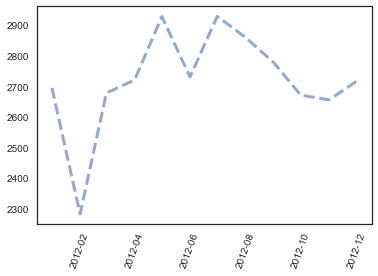

In [52]:
# 2012
plt.plot(monthly_rates.index[:12], monthly_rates['Count'][:12], 
         linestyle='--', linewidth=3., alpha=0.6)
plt.xticks(rotation=70)
plt.tick_params(axis='both', which='both',length=0)
plt.show()

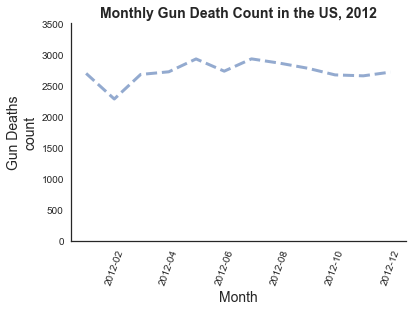

In [53]:
# notice the y column in the previous plot begins at 2200; 
# Let's look at the real picture from 0 
plt.plot(monthly_rates.index[:12], monthly_rates['Count'][:12],
        linestyle='--', linewidth=3., alpha=0.6)
plt.xticks(rotation=70)
plt.ylim(ymin=0, ymax=3500)
plt.tick_params(axis='both', which='both',length=0)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Gun Deaths\ncount', fontsize=14)
plt.title('Monthly Gun Death Count in the US, 2012', fontsize=14, fontweight='bold')
sns.despine()
plt.show()

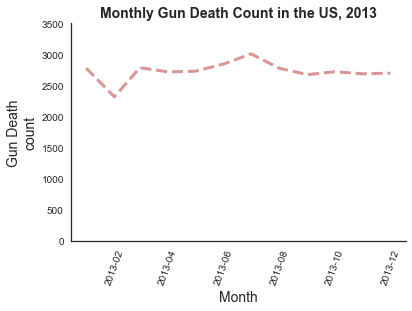

In [54]:
# year 2013:
plt.plot(monthly_rates.index[12:24], monthly_rates['Count'][12:24],
        linestyle='--', linewidth=3., alpha=0.6, color='r')
plt.xticks(rotation=70)
plt.ylim(ymin=0, ymax=3500)
plt.tick_params(axis='both', which='both',length=0)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Gun Death\ncount', fontsize=14)
plt.title('Monthly Gun Death Count in the US, 2013', fontsize=14, fontweight='bold')
sns.despine()
plt.show()

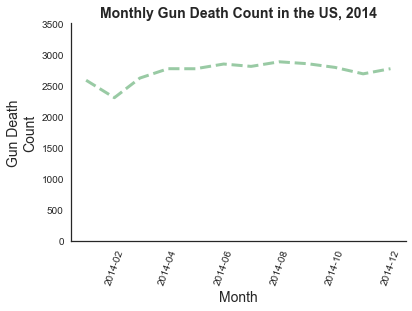

In [55]:
# year 2014:
plt.plot(monthly_rates.index[24:], monthly_rates['Count'][24:],
        linestyle='--', linewidth=3., alpha=0.6, color='g')
plt.xticks(rotation=70)
plt.ylim(ymin=0, ymax=3500)
plt.tick_params(axis='both', which='both',length=0)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Gun Death\nCount', fontsize=14)
plt.title('Monthly Gun Death Count in the US, 2014', fontsize=14, fontweight='bold')
sns.despine()
plt.show()

Let's print them on the same plot in order to compare:

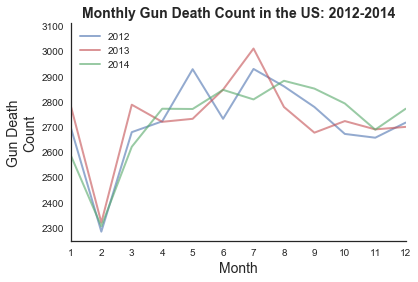

In [56]:
# years 2012 - 2014
# Changing linestyle to a constant line = seeing intersections more clearly
fig = plt.figure()
plt.plot(monthly_rates.index.month[0:12], monthly_rates['Count'][0:12], label='2012',
        linestyle='-', linewidth=2., alpha=0.6)
plt.plot(monthly_rates.index.month[12:24], monthly_rates['Count'][12:24], label='2013',
        linestyle='-', linewidth=2., alpha=0.6, color='r')
plt.plot(monthly_rates.index.month[24:36], monthly_rates['Count'][24:36], label='2014',
        linestyle='-', linewidth=2., alpha=0.6, color='g')
plt.xlim(xmin=1, xmax=12)
plt.ylim(ymax=max(monthly_rates['Count'])+100)
plt.tick_params(axis='both', which='both',length=0)
plt.xticks(np.arange(1, 13, 1))
plt.legend(loc='upper left', frameon=False)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Gun Death\nCount', fontsize=14)
plt.title('Monthly Gun Death Count in the US: 2012-2014', fontsize=14, fontweight='bold')
sns.despine()
plt.show()

But this is a distorted look on the data. It's important our axis starts from 0. Also, let's not repeat ourselves and enlarge the plot:

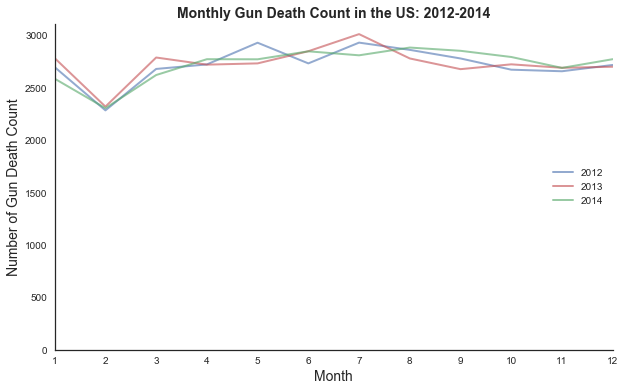

In [57]:
fig = plt.figure(figsize=(10,6))

colors = ['b', 'r', 'g']
labels = ['2012', '2013', '2014']

for i in range(len(labels)):
    start_index = i*12
    end_index = (i+1)*12
    subset = monthly_rates[start_index:end_index]
    plt.plot(subset.index.month, subset['Count'], color=colors[i], label=labels[i],
            linestyle='-', linewidth=2., alpha=0.6)

plt.xlim(xmin=1, xmax=12)
plt.ylim(ymin=0, ymax=max(monthly_rates['Count'])+100)
plt.tick_params(axis='both', which='both',length=0)
plt.xticks(np.arange(1, 13, 1))
plt.legend(loc='center right', frameon=False)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Gun Death Count', fontsize=14)
plt.title('Monthly Gun Death Count in the US: 2012-2014', fontsize=14, fontweight='bold')
sns.despine()
plt.show()

The trend of deaths does not seem to vary significantly over the years. There is a recurring phenomenon of very low number of incidents during february. July has the highest rate of gun deaths in 2012 and 2013, but it is not the case in 2014.

### Bar Plots

When we need visualization that scales graphical objects to the quantitative values we're interested in comparing - we can use a **bar plot**.

Let's look at the 'intent' division with inner gender ['sex'] division.

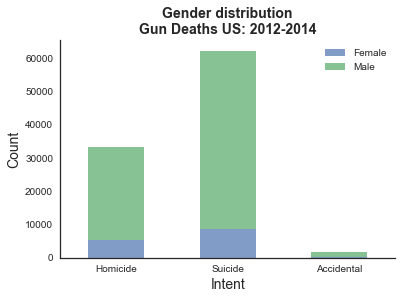

In [58]:
intent_sex = guns.groupby(['Intent', 'Sex'])['Intent'].count().unstack('Sex')
ax = intent_sex.plot(kind='bar', stacked=True, alpha=0.7)
ax.set_xlabel('Intent', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
plt.xticks(rotation=0)
plt.tick_params(axis='both', which='both',length=0)
ax.legend(labels=['Female', 'Male'], frameon=False, loc=0)
plt.title('Gender distribution\nGun Deaths US: 2012-2014', fontsize=14, fontweight='bold')
sns.despine()
plt.show()

There are far more male incidents than female. From this visual we can infer that it will be hard to learn from 'Accidental' cases since there is so little of them.

We can look at a similar split to get a sence of the education of the victims:

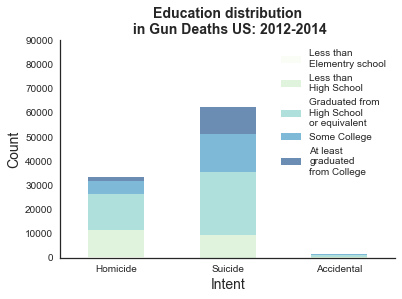

In [59]:
intent_edu = guns.groupby(['Intent', 'Education'])['Intent'].count().unstack('Education')
# creating a range of 5 colors - from light to dark
edu_legend_labels = ['Less than\nElementry school','Less than \nHigh School', 'Graduated from\nHigh School\nor equivalent', 
                 'Some College', 'At least\ngraduated\nfrom College']
colors = plt.cm.GnBu(np.linspace(0, 1, 5))
ax = intent_edu.plot(kind='bar', stacked=True, color=colors, width=0.5, alpha=0.6)
plt.xticks(rotation=0)
ax.set_xlabel('Intent', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
plt.tick_params(axis='both', which='both',length=0)
ax.legend(edu_legend_labels, ncol=1, frameon=False, prop={'size':10}, loc=0)
plt.ylim(ymin=0, ymax=90000)
plt.title('Education distribution\n in Gun Deaths US: 2012-2014', fontsize=14, fontweight='bold')
sns.despine()
plt.show()

But this is too crowded, so let's make it horizontal and spread it out a bit:

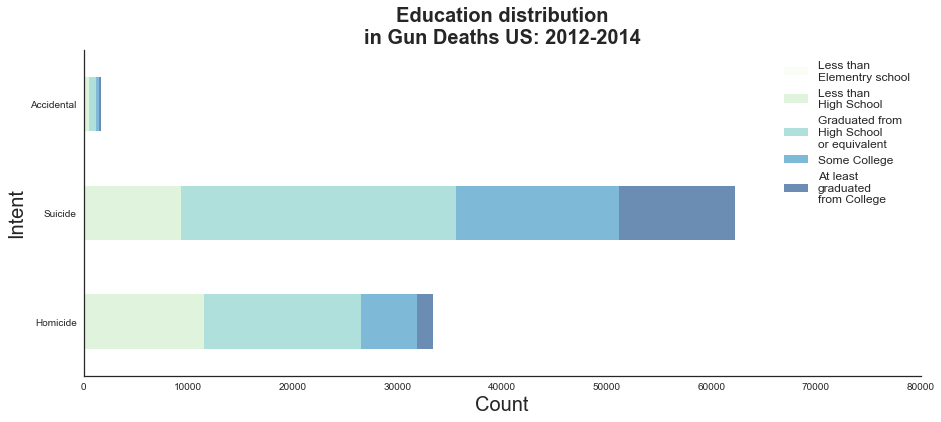

In [60]:
intent_edu = guns.groupby(['Intent', 'Education'])['Intent'].count().unstack('Education')
ax = intent_edu.plot(kind='barh', figsize=(15,6), stacked=True, color=colors, alpha=0.6)
ax.set_xlabel('Count', fontsize=20)
ax.set_ylabel('Intent', fontsize=20)
ax.legend(edu_legend_labels, loc=0,  prop={'size':12}, frameon=False)
plt.xlim(xmin=0, xmax=80000)
plt.tick_params(axis='both', which='both',length=0)
plt.title('Education distribution\nin Gun Deaths US: 2012-2014', fontsize=20, fontweight='bold')
sns.despine()
plt.show()

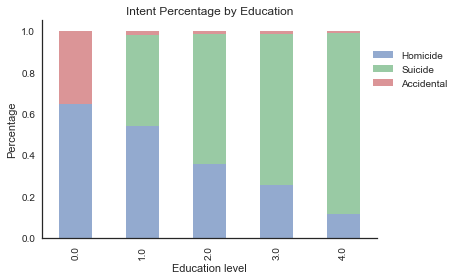

In [61]:
1# the percentage visual is more informative
education = pd.crosstab(guns.Education, guns.Intent)
education.div(education.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, alpha=0.6)
plt.title('Intent Percentage by Education')
plt.xlabel('Education level')
plt.ylabel('Percentage')
plt.legend(loc='upper center', bbox_to_anchor=(1.1,0.9))
sns.despine()

Using this split visualization we can see that there is a larger percentage of people with some college education and higher in the suicide gun deaths than in the Homicide incidents. The dark blues are more than a third of the Suicide cases, but only about a quarter of the Homicide cases. This is indication that **'education' could be a helpful variable for our 'intent' prediction.**

Again, the Accidental bar does not seem to give us any additional info. It may be useless for our prediction, and we're better off going with binary: 'Suicide' vs. 'Homicide'.

Moving on to distribution of location:

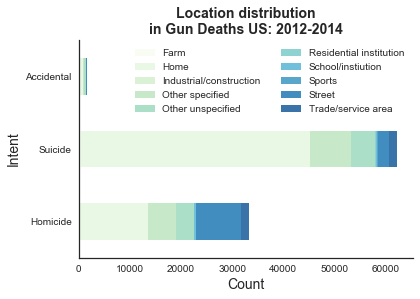

In [62]:
intent_place = guns.groupby(['Intent', 'Place'])['Intent'].count().unstack('Place')

colors = plt.cm.GnBu(np.linspace(0, 2, 20))
ax = intent_place.plot(kind='barh', stacked=True, color=colors, alpha=0.8)
ax.set_xlabel('Count', fontsize=14)
ax.set_ylabel('Intent', fontsize=14)
plt.tick_params(axis='both', which='both', length=0)
ax.legend(loc=0, ncol=2, prop={'size':10}, frameon=False)
plt.title('Location distribution\nin Gun Deaths US: 2012-2014', fontsize=14, fontweight='bold')
sns.despine()
plt.show()

We can see that most cases of Suicide happen at home. This means that **location could be an important variable when we want to predict intent**. The Accidental column, again, seems too dense to give us any valuble info. 

It's almost impossible to conclude things about this visualization since there are a lot of values (i.e colors), and this distribution isn't that useful for us. Let's make it better by merging some of the values. 

In [63]:
guns.Place.value_counts()

Home                       59146
Other specified            13472
Street                     10989
Other unspecified           8625
Trade/service area          3374
School/instiution            659
Farm                         465
Industrial/construction      238
Residential institution      201
Sports                       125
Name: Place, dtype: int64

I'm not sure if the values 'other specified' and 'other unspecified' give us any info. We may want to drop this column all together, or chose: Home, Street and other as our 3 values for this.

In [64]:
#These are too many categories and it's hard to arrive to conclusions
# let's merge 'street' with 'trade/service area' and the rest to 'Other'
index_temp = guns[(guns['Place'] == 'Trade/service area') | (guns.Place == 'Industrial/construction')].index
guns.loc[index_temp, 'Place'] = 'Street'
index_temp = guns[(guns['Place'] != 'Street') & (guns.Place != 'Home')].index
guns.loc[index_temp, 'Place'] = 'Other'

guns.Place.value_counts()

Home      59146
Other     23547
Street    14601
Name: Place, dtype: int64

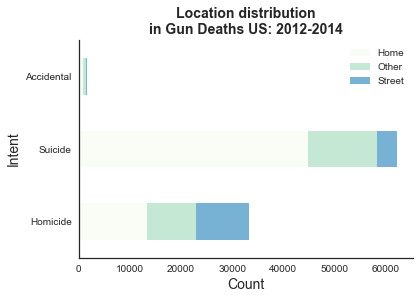

In [65]:
# Let's take another look:
intent_place = guns.groupby(['Intent', 'Place'])['Intent'].count().unstack('Place')
colors = plt.cm.GnBu(np.linspace(0,2,6))
ax = intent_place.plot(kind='barh', stacked=True, color=colors, alpha=0.6)
ax.set_xlabel('Count', fontsize=14)
ax.set_ylabel('Intent', fontsize=14)
plt.tick_params(axis='both', which='both',length=0)
ax.legend(loc='upper right', prop={'size':10}, frameon=False)
plt.title('Location distribution\nin Gun Deaths US: 2012-2014', fontsize=14, fontweight='bold')
sns.despine()
plt.show()

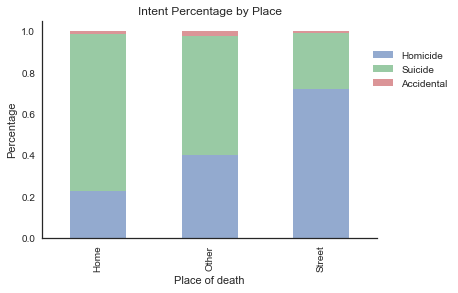

In [66]:
# the percentage visual is more informative
place_died = pd.crosstab(guns.Place, guns.Intent)
place_died.div(place_died.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, alpha=0.6)
plt.title('Intent Percentage by Place')
plt.xlabel('Place of death')
plt.ylabel('Percentage')
plt.legend(loc='upper center', bbox_to_anchor=(1.1,0.9))
sns.despine()

This is far less dense and better for understanding our data. It is not surprising that the minoroty of suicide cases were located in the street, and the majority - at home. Homicide seems to be split 3 ways pretty evenly.

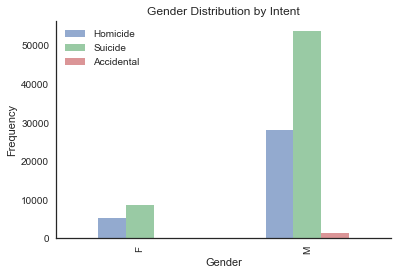

In [67]:
# barplot of gender grouped by intent 
pd.crosstab(guns.Sex, guns.Intent).plot(kind='bar', alpha=0.6)
plt.title('Gender Distribution by Intent')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.legend(loc=0)
sns.despine()


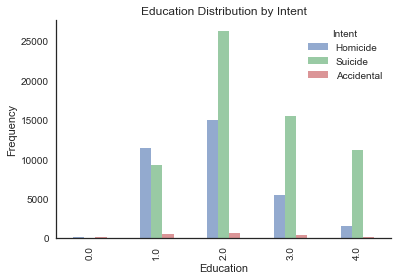

In [68]:
# barplot of education grouped by intent 
pd.crosstab(guns.Education, guns.Intent).plot(kind='bar', alpha=0.6)
plt.title('Education Distribution by Intent')
plt.xlabel('Education')
plt.ylabel('Frequency')
sns.despine()

Let's use a stacked barplot to look at the percentage intent by place of death.

## Histograms

We use value counts and **sort_index()** in order to organize the age values according to frequency. 

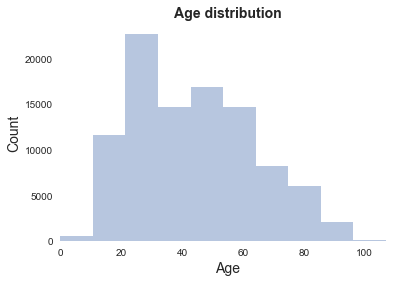

In [69]:
age_freq = guns.Age.value_counts()
sorted_age_freq = age_freq.sort_index()
sorted_age_freq.head()
plt.hist(guns['Age'], range=(0,107), alpha=0.4)
plt.tick_params(axis='both', which='both',length=0)
plt.xlim(xmin=0, xmax=110)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Age distribution', fontsize=14, fontweight='bold')
sns.despine(bottom=True, left=True)
plt.show()

Let's look at the age histogram for the suicide deaths vs. the homicide deaths, and check if there are any evident differences.

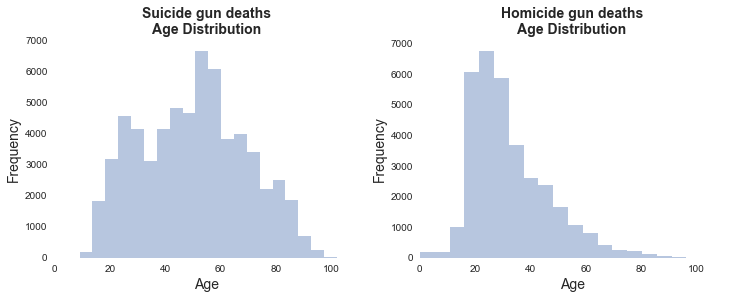

In [70]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

suicide = guns[guns['Intent'] == 'Suicide']
homicide = guns[guns['Intent'] == 'Homicide']

ax1.hist(suicide.Age, 20, alpha=0.4)
ax1.set_title('Suicide gun deaths\nAge Distribution', fontsize=14, fontweight='bold')
ax2.hist(homicide.Age, 20, alpha=0.4)
ax2.set_title('Homicide gun deaths\nAge Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Age', fontsize=14)
ax2.set_xlabel('Age', fontsize=14)
ax1.set_ylabel('Frequency', fontsize=14)
ax2.set_ylabel('Frequency', fontsize=14)
ax1.tick_params(axis='both', which='both',length=0)
ax2.tick_params(axis='both', which='both',length=0)
ax1.set_xlim(xmin=0, xmax=110)
ax2.set_xlim(xmin=0, xmax=110)
sns.despine(bottom=True, left=True)
plt.show()

By looking at this we can see that most of the Homicide deaths occured around the age of 20-21, while most suicide cases are circled just under the age of 55-58 (there is also a noticable peak around the age of 20). If we wanted more accurate numbers - we could take a look at the mean and median of these variables. Again, since we have so little incidents of accidental gun deaths, it's hard to infer anything from that part of the data [red dots].

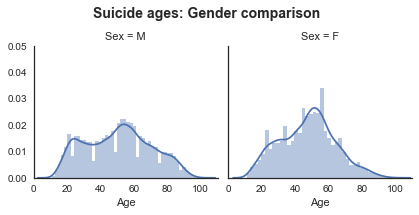

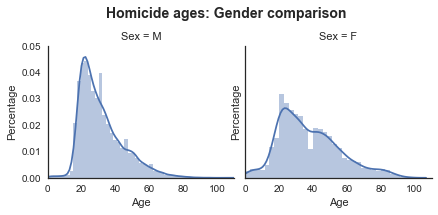

In [71]:
g = sns.FacetGrid(suicide, col='Sex')  
g.map(sns.distplot, 'Age')
plt.subplots_adjust(top=0.8)
g.set(xlim=(0, 110), ylim=(0, 0.05))
g.fig.suptitle('Suicide ages: Gender comparison', fontsize=14, fontweight='bold')
g = sns.FacetGrid(homicide, col='Sex') 
g.map(sns.distplot, 'Age')
plt.subplots_adjust(top=0.8)
g.set(xlim=(0, 110), ylim=(0, 0.05), xlabel='Age', ylabel='Percentage', )
g.fig.suptitle('Homicide ages: Gender comparison', fontsize=14, fontweight='bold')

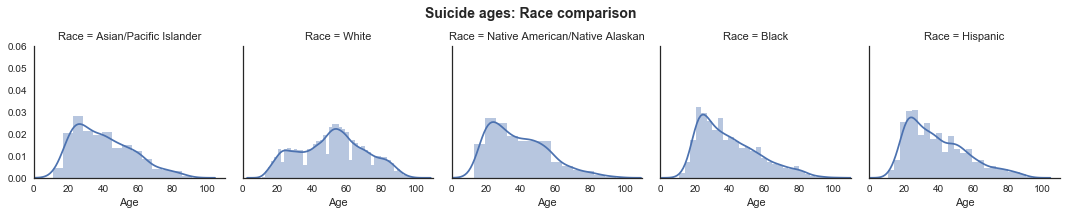

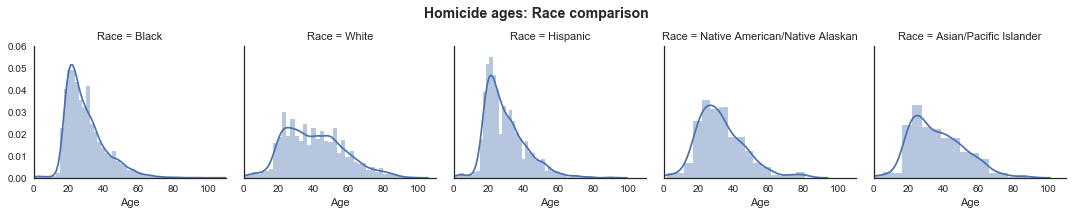

In [72]:
g = sns.FacetGrid(suicide, col='Race')  
g.map(sns.distplot, 'Age')
g.set(xlim=(0, None))
plt.subplots_adjust(top=0.8)
g.set(xlim=(0, 110), ylim=(0, 0.06), xlabel='Age')
g.fig.suptitle('Suicide ages: Race comparison', fontsize=14, fontweight='bold')
g = sns.FacetGrid(homicide, col='Race') 
g.map(sns.distplot, 'Age')
g.set(xlim=(0, None))
plt.subplots_adjust(top=0.8)
g.set(xlim=(0, 110), ylim=(0, 0.06), xlabel='Age')
g.fig.suptitle('Homicide ages: Race comparison', fontsize=14, fontweight='bold')

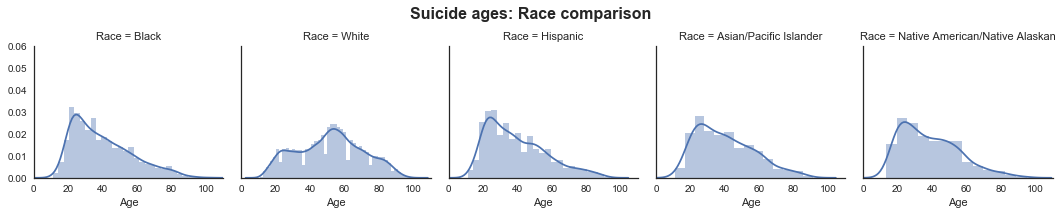

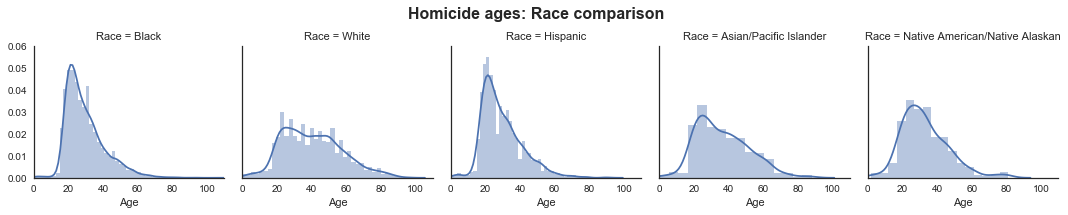

In [73]:
# in order to get in in the same order for better comparison:
race_ordered = ['Black', 'White', 'Hispanic', 'Asian/Pacific Islander', 'Native American/Native Alaskan']
guns['Race'] = guns['Race'].astype('category')
guns.Race.cat.set_categories(race_ordered, inplace=True)

suicide = guns[guns['Intent'] == 'Suicide']
homicide = guns[guns['Intent'] == 'Homicide']

g = sns.FacetGrid(suicide, col='Race')  
g.map(sns.distplot, 'Age')
plt.subplots_adjust(top=0.8)
g.set(xlim=(0, 110), ylim=(0, 0.06), xlabel='Age')
g.fig.suptitle('Suicide ages: Race comparison', fontsize=16, fontweight='bold')
g = sns.FacetGrid(homicide, col='Race') 
g.map(sns.distplot, 'Age')
plt.subplots_adjust(top=0.8)
g.set(xlim=(0, 110), ylim=(0, 0.06), xlabel='Age')
g.fig.suptitle('Homicide ages: Race comparison', fontsize=16, fontweight='bold')

It's very apperant that the peak in most races in both suicide incidents is around age 20, while the peak in the race 'white' is much higher - around 55 in suicide cases. There is a difference in the homicide cases of this race as well.

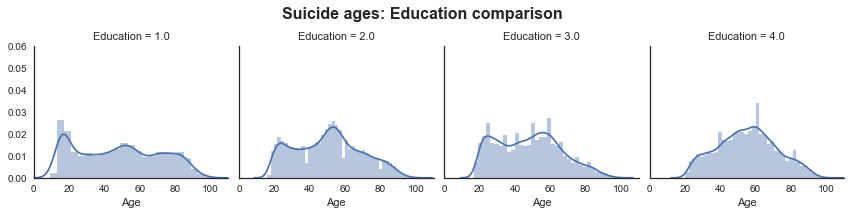

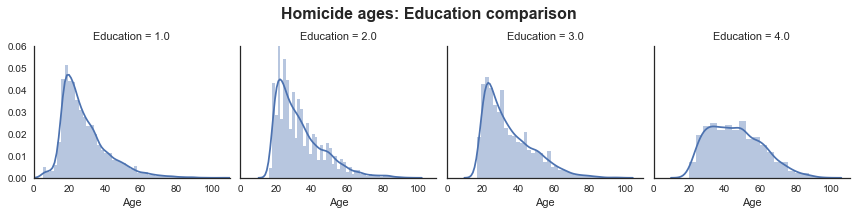

In [74]:
# we can ignore education = 0 - since these are all very young ages
g = sns.FacetGrid(suicide[suicide.Education > 0], col='Education')
g.map(sns.distplot, 'Age')
plt.subplots_adjust(top=0.8)
g.set(xlim=(0, 110), ylim=(0, 0.06), xlabel='Age')
g.fig.suptitle('Suicide ages: Education comparison', fontsize=16, fontweight='bold')
g = sns.FacetGrid(homicide[homicide.Education > 0], col='Education') 
g.map(sns.distplot, 'Age')
plt.subplots_adjust(top=0.8)
g.set(xlim=(0, 110), ylim=(0, 0.06), xlabel='Age')
g.fig.suptitle('Homicide ages: Education comparison', fontsize=16, fontweight='bold')

In [75]:
suicide.Education.value_counts()

2.0    26321
3.0    15532
4.0    11147
1.0     9295
Name: Education, dtype: int64

The peaks show an interesting picture: All of the homicides plot peaks are in the area of 20 years old, and this is similar for suicides in cases where the education was low. However, when the victim was of college university [3.0-4.0] the peak is also around age 60.
This may mean that age can also help us predict intent.

## KDE Plot

This plot is useful for looking at univariate relations. It creates and visualizes a kernel density estimate of the underlying feature.

Let's look at the age values:

This view will make it look like there are negative ages in our dataset, but that is not the case. The reason for that is that KDE smoothes the lines and thus manipulates the truth. We can limit the x axis.

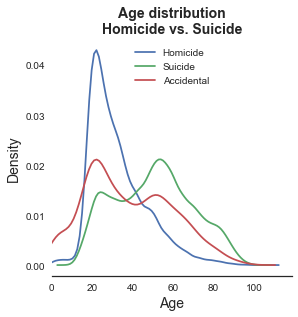

In [76]:
# limit the x-axis
sns.FacetGrid(guns, hue='Intent', size=4).map(sns.kdeplot, 'Age')
plt.legend(loc=9, frameon=False)
plt.xlim(xmin=0)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Density', fontsize=14)
sns.despine(left=True)
plt.title('Age distribution\nHomicide vs. Suicide', fontsize=14, fontweight='bold')

This is very similar to the plot we saw before, only seeing it on the same grid makes it easier to see differences.

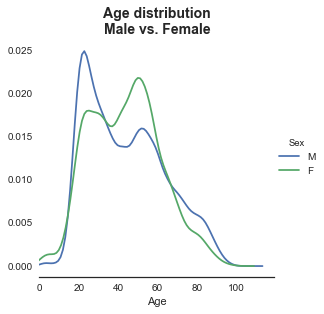

In [77]:
sns.FacetGrid(guns, hue='Sex', size=4).map(sns.kdeplot, 'Age').add_legend()
sns.despine(left=True)
plt.xlim(xmin=0)
plt.title('Age distribution\nMale vs. Female', fontsize=14, fontweight='bold')

This is also very useful in seeing differences between the genders. Let's make different KDE plots for each intent:

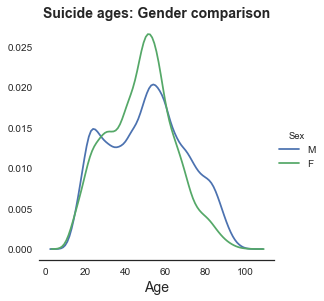

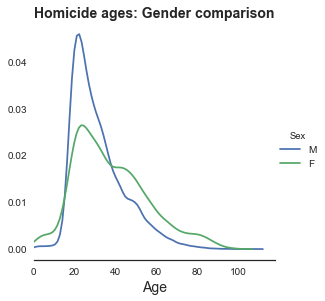

In [78]:
sns.FacetGrid(suicide, hue='Sex', size=4).map(sns.kdeplot, 'Age').add_legend()
plt.xlabel('Age', fontsize=14)
sns.despine(left=True)
plt.title('Suicide ages: Gender comparison', fontsize=14, fontweight='bold')
sns.FacetGrid(homicide, hue='Sex', size=4).map(sns.kdeplot, 'Age').add_legend()
plt.xlabel('Age', fontsize=14)
sns.despine(left=True)
plt.xlim(xmin=0)
plt.title('Homicide ages: Gender comparison', fontsize=14, fontweight='bold')

# Box Plots
A box plot consists of box-and-whisker diagrams, which represents the different quartiles in a visual way. It is useful to show differences between different groups in our data.

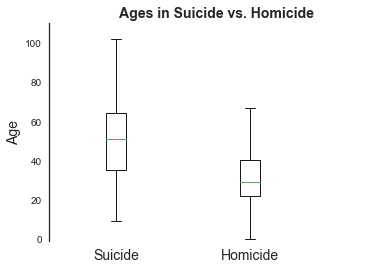

In [79]:
fig, ax = plt.subplots()
data_to_plot = [suicide.Age, homicide.Age]
plt.xlim(xmin=0, xmax=110)
plt.boxplot(data_to_plot)
plt.ylim(ymin=-1, ymax=110)
plt.xticks([1, 2, 3], ['Suicide', 'Homicide'], fontsize=14)
plt.tick_params(axis='both', which='both',length=0)
plt.ylabel('Age', fontsize=14)
plt.title('Ages in Suicide vs. Homicide',
          fontsize=14, fontweight='bold')
sns.despine(bottom=True)
plt.show()

Another useful tool is the ability to split column by their value. Here we are doing a gender comparison of age in each 'intent' value:

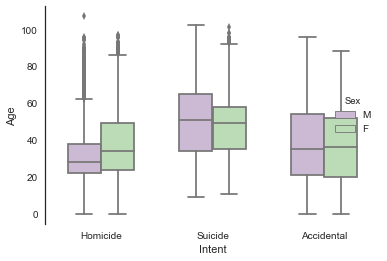

In [80]:
#sns.set(style='ticks')
sns.boxplot(x='Intent', y='Age', hue='Sex', data=guns, palette='PRGn', width=0.6)
sns.despine(bottom=True)

Again we see that Accidental does not give us any additional info.
We see the ages in suicides among women varies more than men. However, there is a smaller variation in the ages of females that are murderd in homicide cases.

## Violin plots

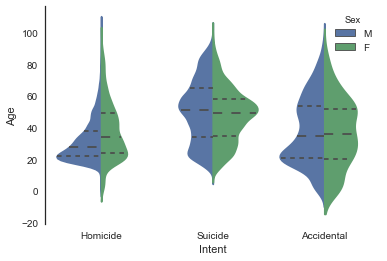

In [81]:
sns.violinplot(x='Intent', y='Age', hue='Sex', split=True, data=guns, size=4, inner='quart')
sns.despine(bottom=True)

This visualization of the variance in each gender help us to better understand the numbers: Again, the accidental column does not give us much info since the distribution and quartiles are very similar between genders. However, we see the distribution between male and female in homicide differs in quartiles and in the range of the quarters. This may mean that combining age and gender can be a helpful predictor.

**Note:** Since most of our variables are categorical, **scatter plots** would not give us much information (believe me, I tried). The same applies to **scatter matrix plot**.

## Main Takeaways
- Age, education, place and age~gender may be helpful in predicting intent.
- Place variable should be used carefuly since some of the values were combined.
- There is a large number of gun deaths during July and June, and a smaller number on February.
- To do: Prediction!

Would love to get your feedback!